## **ETL Pipeline IEMOCAP**

En este *notebook* se sigue un flujo de trabajo estandarizado (**ETL Pipeline**) para la ingesta y preprocesado de los datos, transformando la compleja estructura de archivos de **IEMOCAP** en un formato organizado y útil para el entrenamiento. A diferencia de **MELD**, lo primero que nos llama la atención es que **IEMOCAP** presenta una estructura de directorios anidada más compleja y desordenada, además de que incluye datos como la captura de movimiento (los marcadores en la cara) que no usaremos. Este proceso llevado a cabo trata de convertir estos datos crudos y desestructurados en una tabla consolidada.

Los objetivos específicos de este notebook son:

1. **Extracción y Parsing (Extract)**: Se recorre la jerarquía de directorios de las 5 sesiones, leyendo y asociando los archivos de texto (transcripciones) con sus correspondientes archivos de evaluación (etiquetas emocionales discretas y continuas), filtrando archivos basura del sistema. 

2. **Transformación y Edición (Transform)**:

    * Detección y tratamiento de **valores faltantes (NaN)**, **duplicados** (completos e IDs) y ***outliers técnicos*** (errores).

    * **Segmentación de Vídeo (*Clipping*)**: Recortamos los vídeos originales de sesión completa (*.avi*) en clips individuales (*.mp4*) utilizando las marcas de tiempo (timestamps) exactas de cada turno de palabra.

    * **Generación del Target (Variable Objetivo)**: Creación de la variable binaria **target_stress** (Estrés vs. No Estrés) mediante el mapeo de las emociones originales (Ira, Frustración, Miedo) basado en el Modelo Circumplejo de Russell (Alta Activación + Valencia Negativa). En este caso, a diferencia de **MELD**, se mapea la emoción de **Frustración** como **Estrés**.

        * ***Nota***: Aquellas instancias etiquetadas como *Other* (`oth` y `xxx`), se eliminan del dataset, ya que no reflejan un estado afectivo concreto, sino una discrepancia o falta de consenso. Esta limpieza es necesaria para evitar la introducción de ruido y garantizar un entrenamiento basado exclusivamente en instancias validadas y sin ambigüedad. No tenemos en cuenta la **Valencia**, **Activación** y **Dominancia** en estas instancias, ya que al derivar de evaluaciones contradictorias, los valores promedios de estas dimensiones resultarían poco fiables, lo que podría confundir la frontera de decisión del modelo.

    * **Estandarización** de formatos y codificaciones.

    * **Carga (*Load*)**: Consolidación de toda la información multimodal en un único dataset (`IEMOCAP_clean.csv`) y almacenamiento de los clips de vídeo procesados, dejando los datos listos para el Análisis Exploratorio (EDA) y el modelado.

    

En la estructura de directorios de **IEMOCAP**, nos centramos en **3 rutas**:
- **Las Etiquetas (Emociones + VAD)**: Presentes en *SessionX/dialog/EmoEvaluation/*. Son archivos *.txt*.

- **El Texto (Transcripciones)**: Están en *SessionX/dialog/transcriptions/*.

- **El Audio/Vídeo**: 
    * Los Audios recortados (*utterances*) en *SessionX/sentences/wav/*.
    * Los vídeos completos (conversaciones enteras, que deberemos recortar por turnos) en *SessionX/dialog/avi/divX/*. 

In [1]:
!pip install tqdm moviepy==1.0.3 decorator==4.4.2 opencv-python

In [ ]:
# Carga de librerías y paquetes necesarios para la ejecución del notebook

import os
import re
import pandas as pd
import glob
import html
import cv2
import wave
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURACIÓN DE RUTAS ---
# Ruta base de datos
DATA_ROOT = "../data"  # Se indica la ruta donde se encuentran todos los datos para el proyecto
RAW_PATH = os.path.join(DATA_ROOT, "RAW", "IEMOCAP")  # Específicamente, datos en crudo de IEMOCAP
PROCESSED_PATH = os.path.join(DATA_ROOT, "PROCESSED")  # Ruta donde se guardarán los datos procesados (limpios) de IEMOCAP
FIGURAS_PATH = "../figuras"  # Ruta donde se guardarán las figuras generadas
CLIPS_DIR = "IEMOCAP_CLIPS" # Directorio donde se almacenarán los clips extraídos de los vídeos

OUTPUT_CSV = os.path.join(PROCESSED_PATH, "IEMOCAP_clean.csv")


---
## **Ingesta y preprocesamiento (transform) en IEMOCAP**

Al no contar con un **CSV** que incluya todos los datos, como en el caso de **MELD**, debemos de crearlo con lo que necesitamos para el modelo.

La estructura de directorios que presenta **IEMOCAP** es la siguiente:

* **Nivel Superior (Sesiones)** : El *dataset* se divide en **5 carpetas** principales (desde la **Session1** a **Session5**), cada una correspondiente a una sesión de grabación distinta con una pareja de actores diferente. Todas comparten la misma subestructura interna.

    ***Nota sobre la nomenclatura***: Dentro de cada sesión, los nombres de directorio y archivo pueden contener una "F" o una "M" (ej: Ses01F o Ses01M). Esto indica qué actor llevaba los marcadores de captura de movimiento en ese bloque específico (F = Female/Mujer, M = Male/Hombre), aunque en todos los diálogos participan ambos interlocutores. Para nuestro proyecto, esto no lo tendremos en cuenta.

* **Subniveles Relevantes para nuestro Proyecto (dentro de cada Sesión)**:

    * `dialog/EmoEvaluation/`: Contiene los ficheros *.txt* con las **etiquetas categóricas** (*Anger*, *Happiness*, *Sadness*, *Neutral*, *Excitement*, *Frustration*, *Fear*, *Surprise*, *Other*) y los valores dimensionales (Valencia, Activación, Dominancia) alineados por turno o *utterance*. 
        * Tenemos dos tipos de ficheros presentes en este directorio:
            * SesXYZ_improXY: Estos archivos que llevan `impro` en su nombre (ej: `Ses01F_impro01`) corresponden a sesiones de improvisación. Estas se grabaron cuando a los actores no se les dio un guión. Solo se les dio una "situación" o escenario, y a raíz de este contexto los actores improvisaron.
            * SesXYZ_scriptXY: Estos ficheros con la palabra `script` en su nombre (ej: `Ses01F_script01_1`) corresponden a guiones de teatro. 

            ***Nota***: Cada frase o turno es evaluada por **3 o 4 personas**, y en aquellas en las que no se ponían de acuerdo, ponían la etiqueta `xxx`. Nosotros mapearemos esta etiqueta como `Other` para mayor simplicidad.

    * `dialog/transcriptions/`: Almacena las **transcripciones textuales** junto con las marcas de tiempo (*timestamps*) de inicio y fin exactas para cada intervención (turno).
        * Los ficheros presentes en este directorio son *.txt* divididos en los mismos dos grupos (`impro` y `script`) al igual que los ficheros de **EmoEvaluation**.

    * `sentences/wav/`: Contiene los archivos de **audio** (*.wav*) ya segmentados por turno de palabra o *utterance*.
        * La relación con las transcripciones es directa: si el fichero Ses01F_impro01 en *transcriptions* indica 30 intervenciones, en esta carpeta encontraremos los 30 archivos de audio individuales correspondientes a cada frase.  

    * `dialog/avi/divX/`: Ubicación de los archivos de **vídeo** originales (*.avi*) que contienen la escena completa sin recortar, necesarios para la extracción posterior de los clips visuales.


En conclusión, tras procesar las 5 sesiones, el dataset consolida un total de 151 diálogos que suman 10.037 turnos, intervenciones o utterances.

####    **1. Extracción (ingesta) de los metadatos de las 5 sesiones y creación del **DataFrame IEMOCAP**:**

En la siguiente celda de código, se recorre toda la estructura descrita, extrayendo la información y rutas, almacenándolas en un DataFrame.

In [2]:
def extraccion_metadatos_iemocap(dataset_path, clip_path):
    """
    Recorre la estructura de directorios de IEMOCAP, extrae información multimodal y consolida un DataFrame.
    
    Proceso ETL (Extract, Transform, Load) realizado:
    1. Extract: Se recorre la estructura de directorios y localiza pares de archivos (Texto y Evaluación).
    2. Transform: 
       - Extrae timestamps (inicio/fin) para el recorte de vídeo.
       - Normaliza etiquetas emocionales.
    3. Load: Genera una lista de diccionarios estructurados.

    Args:
        dataset_path (str): Ruta raíz donde se encuentra la carpeta 'Session1', 'Session2', etc.
        clip_path (str): Ruta relativa donde se almancenarán los clips extraídos de los videos.

    Returns:
        pd.DataFrame: DataFrame con columnas [Utterance_ID, Emotion, Text, Start_Time, End_Time, Paths...]
                      Si la ruta no existe, lanza FileNotFoundError.
    """

    # Se lanza error cuando la ruta indicada es incorrecta
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"No encuentro la carpeta: {dataset_path}")

    # Lista vacía en donde se irá almacenando todos los datos RELEVANTES asociados a cada turno o utterance
    data = []

    # Diccionario de mapeo (Código de Emoción --> Nombre Completo Emoción)
    # Con esto convertimos las etiquetadas asignadas "neu", "ang", "xxx",... en "neutral", "anger", "other",...
    # Con esto normalizamos las etiquetas para que, aquellas compartidas con MELD, reciban el mismo nombre
    emo_map = {
        'neu': 'neutral',
        'ang': 'anger',
        'hap': 'joy',
        'sad': 'sadness',
        'exc': 'excitement', # NO COMPARTIDA CON MELD
        'fru': 'frustration', # NO COMPARTIDA CON MELD
        'fea': 'fear',
        'sur': 'surprise',
        'oth': 'other', # NO COMPARTIDA CON MELD
        'xxx': 'other' # 'xxx' es desacuerdo, lo trataremos como 'other' para mayor simplicidad
        # No incluímos Disgust (Asco), esta clase se tratará a continuación
    }
    
    for session_id in range(1, 6):

        # -------------------- 1. Recorremos los directorios SessionX ---------------------

        session_name = f'Session{session_id}'
        session_path = os.path.join(dataset_path, session_name)
        
        if not os.path.exists(session_path): 
            continue # Si la carpeta SessionX no existe en la ruta indicada, entonces continuamos a la siguiente

        # --------------- 2. Acceso a los subdirectorios más RELEVANTES para el Proyecto ------------------

        emo_eval_dir = os.path.join(session_path, 'dialog', 'EmoEvaluation') # <-- RUTA DE LOS FICHEROS .txt con las etiquetas categóricas
        trans_dir = os.path.join(session_path, 'dialog', 'transcriptions') # <-- RUTA RELATIVA DE LAS TRANSCRIPCIONES junto con timestamps
        

        # ------------------------ 3. Extracción Timestamps de Transcriptions, Etiqueta Categoría Emocional y Audio de cada Turno -------------------------

        # Con glob.glob se devuelve un conjunto de strings con las rutas a los ficheros que coinciden con el patrón 'SessionX/dialog/EmoEvaluation/*.txt'
        eval_files = glob.glob(os.path.join(emo_eval_dir, '*.txt'))
        
        # Se recorre cada uno de esos ficheros (rutas)
        for eval_file in eval_files:
            filename = os.path.basename(eval_file) # extraemos el nombre completo del fichero en concreto

            # En el caso en el que el fichero comience con ._, se trata por tanto de archivos basura del sistema operativo de Apple, lo llamados archivos AppleDouble, que comienzan siempre con ._ y que no debemos tener en cuenta
            if filename.startswith('._') or not filename.startswith('Ses'): 
                continue

            # Nombre del fichero presente en EmoEvaluation:
            file_id = filename.split('.')[0] # Ej: Ses01F_impro01

            # Nombre del fichero presente en transcriptions:
            trans_file = os.path.join(trans_dir, file_id + '.txt') # Ej: Ses01F_impro01.txt

            # Buscamos el vídeo "Padre" (el completo que vamos a recortar)
            # El vídeo se llama igual que el diálogo: Ses01F_impro01.avi
            # También aplicamos la corrección de la ruta para mejorar la compatibilidad (establecemos "/")
            path_source_video = os.path.join(session_name, 'dialog', 'avi', 'DivX', file_id + '.avi').replace("\\", "/")
            
            if not os.path.exists(trans_file): 
                continue 
                
            #  =================================================================
            # PASO 1: LECTURA DE TRANSCRIPCIONES (Texto + Tiempos)
            # =================================================================
            # En el diccionario text_metal, almacenamos una tupla: {id: (texto, start, end)} POR CADA TURNO/UTTERANCE (ej: ID -> Ses01F_impro01_F000)
            # Estos datos los extraemos de los ficheros con las transcripciones, que debemos abrir uno a uno
            text_meta = {}
            with open(trans_file, 'r', encoding='utf-8', errors='ignore') as f_trans:
                for line in f_trans:
                    if "Mac OS X" in line or "ATTR" in line: # Explícitamente ignoramos aquellos archivos basura del sistema operativo de Apple
                        continue
                    
                    # Aplicamos una Regex para capturar los tiempos:
                    # Ses01F_impro01_F000 [6.2901-8.2357]: What a beautiful day! 
                    match = re.match(r"(Ses\w+)\s+\[([0-9\.]+)-([0-9\.]+)\]:\s+(.*)", line)
                    if match:
                        utt_id = match.group(1) # (Ses\w+) --> Ses01F_impro01_F000
                        start_time = float(match.group(2)) # ([0-9\.]+) --> 6.2901
                        end_time = float(match.group(3)) # tras el guión: ([0-9\.]+) ---> 8.2357
                        text = match.group(4).strip() # (.*) --> What a beautiful day! 
                        
                        # Almacenamos en nuestro diccionario la tupla 

                        text_meta[utt_id] = {
                            'text': text,
                            'start': start_time,
                            'end': end_time
                        }

            # =================================================================
            # PASO 2: LECTURA DE ETIQUETAS (Emoción + VAD) Y FUSIÓN
            # =================================================================

            # Abrimos los ficheros de texto en EmoEvaluation con la etiqueta categórica
            with open(eval_file, 'r', encoding='utf-8', errors='ignore') as f_eval:
                for line in f_eval:

                    # Primera línea descartada:

                    if line.startswith('%') or not line.strip() or "Ses" not in line: 
                        continue # La primera línea de los ficheros en EmoEvaluation indica los nombres de las columnas únicamente() % [START_TIME - END_TIME] TURN_NAME EMOTION [V, A, D] ), por tanto la ignoramos

                    # Para el resto de líneas del fichero ej: [6.2901 - 8.2357]	Ses01F_impro01_F000	neu	[2.5000, 2.5000, 2.5000]

                    match_id = re.search(r"(Ses\w+)", line) # Extraemos el ID de dicho diálogo (ej: Ses01F_impro01_F000)
                    if not match_id: 
                        continue
                    utt_id = match_id.group(1)
                    
                    match_emo = re.search(r"\t(neu|ang|hap|sad|exc|fru|fea|sur|oth|xxx)\t", line) # Extraemos la etiqueta que indica la emoción
                    if not match_emo: 
                        continue

                    # Normalizamos la etiqueta (minúscula y quitamos espacios extra):
                    raw_emo = match_emo.group(1).lower().strip()

                    # MAPEO: Usamos el diccionario para obtener el nombre completo
                    # Si por lo que sea sale un código raro que no está en la lista, devuelve el original (get)
                    emotion = emo_map.get(raw_emo, raw_emo)
                    
                    match_vad = re.search(r"\[([0-9\.]+),\s*([0-9\.]+),\s*([0-9\.]+)\]", line) # Extraemos los valores de Valencia, Activación y Dominancia ([x, y, z])
                    val, aro, dom = (float(match_vad.group(1)), float(match_vad.group(2)), float(match_vad.group(3))) if match_vad else (None, None, None)
                    
                    # Rutas Audio
                    # Extraemos el audio asociado a dicho turno o utterance de la línea leída en el fichero de EmoEvaluation
                    # También aplicamos la corrección de la ruta para mejorar la compatibilidad (establecemos "/")
                    dialog_prefix = '_'.join(utt_id.split('_')[:-1]) # Ses01F_impro01_F000 -> ['Ses01F', 'impro01', 'F000'] -> quitamos el último elemento: ['Ses01F', 'impro01'] -> join: 'Ses01F_impro01'
                    full_wav_path = os.path.join(session_name, 'sentences', 'wav', dialog_prefix, utt_id + '.wav').replace("\\", "/") #Ej: Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav
                    
                    # Definimos dónde guardaremos el vídeo recortado
                    processed_video_path = f"{clip_path}/{utt_id}.mp4".replace("\\","/") # aplicamos corrección para prevenir (en el caso en el que clip_path tuviera presente alguna "\")
                    
                    if utt_id in text_meta:
                        data.append({
                            'Utterance_ID': utt_id, # <-- ID del turno (ej: Ses01_impro01_F000)
                            'Session': session_id, # <-- ID de la sesión (ej: Ses01)
                            'Emotion': emotion, # <-- Etiqueta normalizada con la emoción (ej: neutral)
                            'Valence': val, # Valencia (float)
                            'Arousal': aro, # Activación (float)
                            'Dominance': dom, #Dominancia (float)
                            'Text': text_meta[utt_id]['text'], # Texto Limpio de la transcripción (ya sea el script o la improvisación)
                            'Start_Time': text_meta[utt_id]['start'], # <--- Start Time del timestamp para cortar el vídeo
                            'End_Time': text_meta[utt_id]['end'],     # <--- End Time del timestamp para cortar el vídeo
                            'Path_Wav_Audio': full_wav_path, # Ruta del Audio completa
                            'Path_Video_Processed': processed_video_path,    # <--- Ruta relativa del clip para dicho turno concreto (VÍDEO CORTADO). Se recortará y se guardará aquí a continuación
                            'Path_Source_Video': path_source_video # ruta del vídeo completo (sin recortar)
                        })

    return pd.DataFrame(data)

# Ejecutamos y guardamos:
df_iemocap = extraccion_metadatos_iemocap(RAW_PATH, CLIPS_DIR)
df_iemocap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Utterance_ID          10037 non-null  object 
 1   Session               10037 non-null  int64  
 2   Emotion               10037 non-null  object 
 3   Valence               10037 non-null  float64
 4   Arousal               10037 non-null  float64
 5   Dominance             10037 non-null  float64
 6   Text                  10037 non-null  object 
 7   Start_Time            10037 non-null  float64
 8   End_Time              10037 non-null  float64
 9   Path_Wav_Audio        10037 non-null  object 
 10  Path_Video_Processed  10037 non-null  object 
 11  Path_Source_Video     10037 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 941.1+ KB


In [3]:
df_iemocap.head()

,Utterance_ID,Session,Emotion,Valence,Arousal,Dominance,Text,Start_Time,End_Time,Path_Wav_Audio,Path_Video_Processed,Path_Source_Video
0,Ses01F_impro01_F000,1,neutral,2.5,2.5,2.5,Excuse me.,6.2901,8.2357,Session1/sentences/wav/Ses01F_impro01/Ses01F_i...,IEMOCAP_CLIPS/Ses01F_impro01_F000.mp4,Session1/dialog/avi/DivX/Ses01F_impro01.avi
1,Ses01F_impro01_F001,1,neutral,2.5,2.5,2.5,Yeah.,10.0100,11.3925,Session1/sentences/wav/Ses01F_impro01/Ses01F_i...,IEMOCAP_CLIPS/Ses01F_impro01_F001.mp4,Session1/dialog/avi/DivX/Ses01F_impro01.avi
2,Ses01F_impro01_F002,1,neutral,2.5,2.5,2.5,Is there a problem?,14.8872,18.0175,Session1/sentences/wav/Ses01F_impro01/Ses01F_i...,IEMOCAP_CLIPS/Ses01F_impro01_F002.mp4,Session1/dialog/avi/DivX/Ses01F_impro01.avi
3,Ses01F_impro01_F003,1,other,2.5,3.0,3.0,You did.,19.2900,20.7875,Session1/sentences/wav/Ses01F_impro01/Ses01F_i...,IEMOCAP_CLIPS/Ses01F_impro01_F003.mp4,Session1/dialog/avi/DivX/Ses01F_impro01.avi
4,Ses01F_impro01_F004,1,other,2.5,3.0,2.5,You were standing at the beginning and you dir...,21.3257,24.7400,Session1/sentences/wav/Ses01F_impro01/Ses01F_i...,IEMOCAP_CLIPS/Ses01F_impro01_F004.mp4,Session1/dialog/avi/DivX/Ses01F_impro01.avi


#### **2. Detección de Valores Faltantes (NaN):**

Se muestra un total de **10037** registros, y cada variable muestra exactamente la misma cantidad de valores no nulos (*non-null*), por tanto, los datos están completos.

#### **3. Detección y tratamiento de duplicados (registros idénticos):**

In [4]:
num_duplicados = df_iemocap.duplicated().sum()
print(f'Número de registros totalmente idénticos en todos los campos: {num_duplicados}')

Número de registros totalmente idénticos en todos los campos: 0


No hay ningún registro duplicado completamente, cada registro es único (al menos uno de sus campos es distinto).

#### **4. Comprobación de la existencia (integridad) física y acceso (legibilidad) básica de los archivos de vídeo, audio y texto (*Sanity Check*):**

In [5]:
def validar_integridad_iemocap(path_wav, path_video_source, text, end_time, start_time):
    """
    Valida la integridad para IEMOCAP:
    1. El archivo WAV existe y es un audio válido.
    2. El archivo de VIDEO FUENTE (.avi) existe y es legible por OpenCV.
    3. El texto no está vacío.
    4. Calcula la duración basada en los timestamps (End - Start).
    
    Returns:
        (bool, str, float): (Valido o No, Mensaje, Duracion)
    """
    
    # 1. CÁLCULO DE DURACIÓN 
    try:
        duration = float(end_time) - float(start_time)
        if duration <= 0:
            return False, "Duración negativa o cero (Timestamps erróneos)", 0.0
    except:
        return False, "Error en Timestamps", 0.0

    # 2. VALIDACIÓN DE AUDIO (.WAV)
    if not os.path.exists(path_wav) or os.path.getsize(path_wav) == 0:
        return False, "Archivo WAV no encontrado o vacío", 0.0
    
    # Verificamos que sea un WAV válido leyendo su cabecera
    try:
        with wave.open(path_wav, 'rb') as w:
            pass # Si abre sin error, es un wav válido
    except Exception:
        return False, "Archivo WAV corrupto (cabecera inválida)", 0.0

    # 3. VALIDACIÓN DE VIDEO FUENTE (.AVI)
    # Solo comprobamos que exista y abra
    if not os.path.exists(path_video_source):
        return False, "Video fuente (.avi) no encontrado", 0.0
    
    try:
        cap = cv2.VideoCapture(path_video_source)
        if not cap.isOpened():
            return False, "Video fuente corrupto (OpenCV no abre)", 0.0
        cap.release()
    except Exception:
        return False, "Error al acceder al video fuente", 0.0

    # 4. VALIDACIÓN DE TEXTO
    txt_str = str(text)
    if not txt_str or len(txt_str.strip()) == 0 or txt_str.lower() == 'nan':
        return False, "Texto vacío o nulo", 0.0

    return True, "OK", duration


tqdm.pandas()

# Aplicamos la validación
validacion = df_iemocap.progress_apply(
    lambda x: validar_integridad_iemocap(
        path_wav = os.path.join(RAW_PATH, x['Path_Wav_Audio']),
        path_video_source = os.path.join(RAW_PATH, x['Path_Source_Video']),
        text = x['Text'],
        end_time=x['End_Time'],
        start_time=x['Start_Time']),
    axis=1,
    result_type='expand')

# Asignamos columnas
df_iemocap[['valid_check', 'valid_msg', 'duration']] = validacion

# --- REPORTE ---
errores = df_iemocap[~df_iemocap['valid_check']]

if not errores.empty:
    print(f"Se han encontrado {len(errores)} registros inválidos.")
    print("Ejemplos de registros corruptos:")
    print(errores[['Utterance_ID', 'valid_msg']].head())
else:
    print("Todos los archivos WAV y AVI fuentes están correctos.")
    df_iemocap = df_iemocap.copy()

df_iemocap = df_iemocap.drop(columns=['valid_check', 'valid_msg'])


  0%|          | 0/10037 [00:00<?, ?it/s]

Todos los archivos WAV y AVI fuentes están correctos.


#### **5. Tratamiento de los archivos corruptos detectados:**

No se ha detectado ningún archivo corrupto. En comparación con **MELD**, que se llegaron a detectar **2** y se eliminaron, esto indica que este *dataset* cuenta con una mayor calidad e integridad.

#### **6. Detección y tratamiento de *outliers* (errores técnicos) en relación a la duración del vídeo:**

En base al campo de `duration` creado, se detecta y trata aquellos vídeos que sean más largos de lo normal y sean por tanto **errores de recolección** (en el vídeo se muestra a más de una persona hablando cuando debería ser solo una).

Para el **tratamiento** de estos errores, se opta por eliminarlos, ya que no aportan nada al análisis posterior del *dataset* (EDA) ni al modelado, y su presencia podría introducir ruido innecesario, además de consumir recursos computacionales inútilmente procesando información inválida.

Estadísticas de duración (segundos):
count    7515.000000
mean        4.561155
std         3.159229
min         0.585000
25%         2.346250
50%         3.610500
75%         5.850000
max        34.138800
Name: duration, dtype: float64


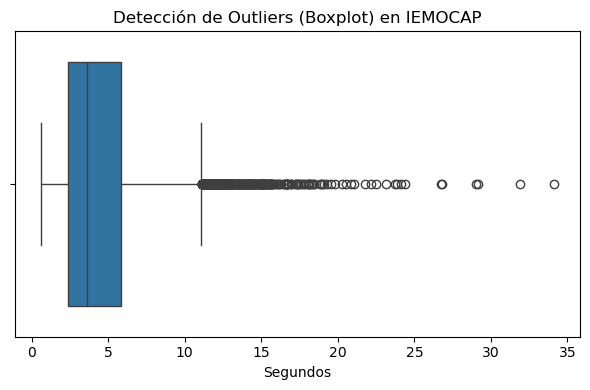

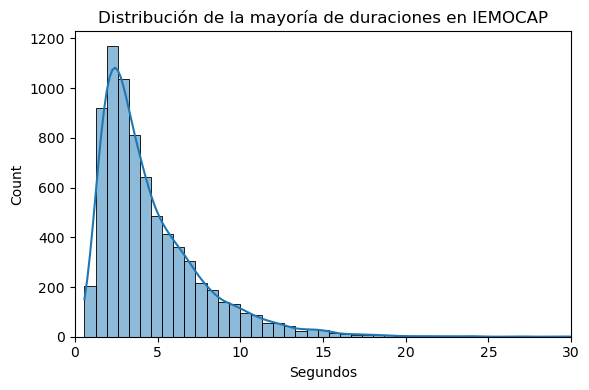

 Top 5 vídeos más largos:
                Utterance_ID  Session  duration
7343  Ses05M_script02_1_M030        5   34.1388
7357  Ses05M_script02_2_F013        5   31.9100
246      Ses01F_impro06_F028        1   29.1300
6567  Ses05F_script02_1_M033        5   29.0465
7393  Ses05M_script02_2_M025        5   26.7730


In [ ]:
# Primero, observamos las estadísticas y una gráfica con la distribución de estas duraciones, y en base a esto decidimos el punto de corte

# Observamos las estadísticas básicas media (mean), máximo (max) y la desviación (std)
stats = df_iemocap['duration'].describe()
print("Estadísticas de duración (segundos):")
print(stats)


# Gráfico 1: Boxplot (Caja y Bigotes) - Para los outliers lejanos
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_iemocap['duration'])
plt.title('Detección de Outliers (Boxplot) en IEMOCAP')
plt.xlabel('Segundos')

plt.tight_layout()

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,"Fig_3_3_1_ETL_IEMOCAP_OutliersDuracion.png"), dpi=300)

plt.show()


# Gráfico 2: Histograma (Zoom en la zona normal)
plt.figure(figsize=(6, 4))
sns.histplot(df_iemocap['duration'], bins=50, kde=True)
plt.xlim(0, 30) 
plt.title('Distribución de la mayoría de duraciones en IEMOCAP')
plt.xlabel('Segundos')

plt.tight_layout()

# Guardamos la imagen:
plt.savefig(os.path.join(FIGURAS_PATH,"Fig_3_3_2_ETL_IEMOCAP_OutliersDuracion.png"), dpi=300)

plt.show()

# Mostramos los 5 vídeos más largos para confirmar que son o no errores
print(" Top 5 vídeos más largos:")
print(df_iemocap[['Utterance_ID', 'Session','duration']].sort_values(by='duration', ascending=False).head(5))

Al no detectarse anomalías tan severas como en el caso de **MELD**, y dado que los vídeos tienen duraciones aceptables (con un máximo de **34** s), no se elimina ninguno.

#### **7. Detección de posibles **IDs duplicados**:**

Esta punto es clave en el preprocesamiento de los datos, ya que si existieran colisiones en los **IDs** asignados a las instancia, dificultaría el análisis y unificación posterior de ambos corpus.

In [7]:
# Verificamos si hay IDs duplicados
# Usamos Session + Utterance_ID como clave única
ids_duplicados = df_iemocap.duplicated(subset=['Session', 'Utterance_ID']).sum()
print(f"IDs duplicados (Session + Utterance_ID): {ids_duplicados}")

IDs duplicados (Session + Utterance_ID): 0


Se confirma la robustez del *dataset*, constatando la ausencia de valores nulos y duplicados. A diferencia de **MELD**, donde se detectaron inconsistencias en los identificadores (**2574 colisiones**), **IEMOCAP** presenta una estructura de etiquetado rigurosa con claves primarias únicas (`Utterance_ID`) que permiten identificar cada muestra de manera inequívoca. Además, se garantiza la completitud de la modalidad textual, disponiendo de transcripciones válidas para la totalidad de los turnos procesados.

* Creación de Variable **`Dialogue_ID`**:

A diferencia de **MELD**, este *dataset* no cuenta con una variable explícita que indique el diálogo o escena concreta dentro de la sesión. Por tanto, se debe de crear una nueva variable `Dialogue_ID` extrayéndola de `Utterance_ID` (por ejemplo, del turno con **ID** `Ses01F_impro01_F000` extraemos `Ses01F_impro01` como **ID** de la escena o diálogo). Esto favorece el posterior análisis y unificación.

In [8]:
# -------- CREACIÓN VARIABLE Dialogue_ID -------------

# Para esto, aplicamos una función lambda a cada valor en Utterance_ID que nos extraiga el ID del diálogo

df_iemocap['Dialogue_ID'] = df_iemocap['Utterance_ID'].apply(lambda x: '_'.join(x.split('_')[:-1])) # Ej: 'Ses01F_impro01_F000' -> ['Ses01F', 'impro01', 'F000'] -> ['Ses01F', 'impro01'] -> 'Ses01F_impro01'

df_iemocap.head(1)

,Utterance_ID,Session,Emotion,Valence,Arousal,Dominance,Text,Start_Time,End_Time,Path_Wav_Audio,Path_Video_Processed,Path_Source_Video,duration,Dialogue_ID
0,Ses01F_impro01_F000,1,neutral,2.5,2.5,2.5,Excuse me.,6.2901,8.2357,Session1/sentences/wav/Ses01F_impro01/Ses01F_i...,IEMOCAP_CLIPS/Ses01F_impro01_F000.mp4,Session1/dialog/avi/DivX/Ses01F_impro01.avi,1.9456,Ses01F_impro01


#### **8. Segmentación de Vídeo:**

En este preprocesamiento realizado del *dataset* de **IEMOCAP**, se debe cortar el vídeo completo, para extraer los *clips* que corresponden a cada uno de los turnos o *utterances*, almacenándolos en las rutas ya indicadas en el campo `Path_Video_Processed` en el *CSV* resultante del código anterior.

Todos estos *clips* se almacenarán en el directorio de `IEMOCAP_CLIPS` dentro de `PROCESSED`.

In [ ]:
from moviepy.video.io.VideoFileClip import VideoFileClip
from tqdm import tqdm # Para mostrar la barra de progreso

# Aseguramos que existe el directorio de destino
os.makedirs(os.path.join(PROCESSED_PATH, CLIPS_DIR), exist_ok=True)


def procesar_recortes_video(df, data_root=PROCESSED_PATH, clips_dir=CLIPS_DIR):
    """
    Toma el DataFrame con los metadatos y recorta los clips de vídeo
    basándose en Start_Time y End_Time.
    """

    # Lista para registrar posibles errores (archivos corruptos, no encontrados, etc.)
    errores = []
    
    # Usamos tqdm para ver una barra de progreso visual
    for index, row in tqdm(df.iterrows(), total=len(df)):
        
        utt_id = row['Utterance_ID']
        source_path = row['Path_Source_Video']
        start = row['Start_Time']
        end = row['End_Time']
        
        # Definimos la ruta de salida final para este clip
        target_path = os.path.join(data_root, clips_dir, utt_id + '.mp4')
        
        # OPTIMIZACIÓN: Si el clip ya existe (de una ejecución anterior), no lo volvemos a cortar
        if os.path.exists(target_path):
            continue
            
        try:
            # Verificamos que el vídeo "padre" existe antes de intentar abrirlo
            if not os.path.exists(source_path):
                # En IEMOCAP puede faltar algún .avi específico o la ruta está mal
                errores.append({'id': utt_id, 'reason': 'Source video not found'})
                continue

            # --- RECORTE del vídeo con  VideoFileClip---
            # 'with' asegura que liberamos la memoria del vídeo al terminar el recorte
            with VideoFileClip(source_path) as video:
                
                # Cortamos el subclip (subclipped gestiona los tiempos flotantes automáticamente)
                new_clip = video.subclipped(start, end)
                
                # Guardamos el resultado
                # codec='libx264' es el estándar para MP4
                # audio_codec='aac' mantiene el sonido
                new_clip.write_videofile(
                    target_path, 
                    codec="libx264", 
                    audio_codec="aac", 
                    temp_audiofile='temp-audio.m4a', #archivo temporal para almacenar el sonido mientras se va cortando y uniendo
                    remove_temp=True, # esto indica que, una vez se cree el .mp4, el archivo temporal temp-audio.m4a se elimine
                    logger=None  # Silencia el output 
                )
                
        except Exception as e:
            # Si falla un vídeo concreto, lo registramos y seguimos con el siguiente
            errores.append({'id': utt_id, 'reason': str(e)})

    return errores

# --- EJECUCIÓN ---

# 1. Cargamos el CSV que generamos en el paso anterior
df_iemocap = pd.read_csv(OUTPUT_CSV)

# 2. Llamamos a la función de recorte
errores_log = procesar_recortes_video(df_iemocap)

# 3. Resultados

if len(errores_log) > 0:
    print(f"Se encontraron {len(errores_log)} errores (vídeos no generados).")
    # Ver los primeros errores:
    print(errores_log[:5]) 
else:
    print("Todos los vídeos se procesaron perfectamente.")

# Verificamos qué clips se han creado realmente y actualizamos la columna Path_Video_Processed

def verificar_ruta_final(utt_id):
    path = os.path.join(PROCESSED_PATH, CLIPS_DIR, utt_id + '.mp4').replace("\\","/")
    return path if os.path.exists(path) else None

df_iemocap['Path_Video_Processed'] = df_iemocap['Utterance_ID'].apply(verificar_ruta_final)


100%|██████████| 10037/10037 [3:50:20<00:00,  1.38s/it]  
Se encontraron 20 errores (vídeos no generados).
[{'id': 'Ses01F_impro04_M036', 'reason': "end_time (202.08) should be smaller or equal to the clip's duration (200.87)."}, {'id': 'Ses01F_script02_1_M044', 'reason': "end_time (331.93) should be smaller or equal to the clip's duration (331.33)."}, {'id': 'Ses01F_script03_1_F031', 'reason': "end_time (279.99) should be smaller or equal to the clip's duration (279.88)."}, {'id': 'Ses01M_impro02_F021', 'reason': "end_time (219.13) should be smaller or equal to the clip's duration (219.02)."}, {'id': 'Ses01M_impro04_M025', 'reason': "end_time (190.83) should be smaller or equal to the clip's duration (190.16)."}]


Estas **20 instancias** en las que no se ha podido generar el *clip* suponen aproximadamente el **0,2%** de muestras (20 de 10037), por tanto, es una tasa de fallo insignificante y se decide eliminarlas a continuación. 

* **Tratamiento y verificación tras la fase de *Video Segmentation* realizada.**

Comprobamos que toda instancia del dataset preprocesado de **IEMOCAP** cuente con su archivo de vídeo (clip) asociado al mismo **ID**, y aquellas que no lo tienen (**20**) son eliminadas. Sin esta verficación y filtrado, no se podría pasar al análisis posterior ni serviría como entrada para el entrenamiento del modelo.

In [9]:
def verificar_archivo(row, clips_ruta):
    """
    Comprueba si existe el archivo .mp4 correspondiente al Utterance_ID.
    Asumimos que el nombre del archivo es {Utterance_ID}.mp4
    """
    nombre_archivo = f"{row['Utterance_ID']}.mp4"
    ruta_completa = os.path.join(clips_ruta, nombre_archivo)
    
    return os.path.exists(ruta_completa)

# 1. Aplicamos la verificación
df_iemocap['exists'] = df_iemocap.apply(verificar_archivo, axis=1, args=(os.path.join(PROCESSED_PATH, CLIPS_DIR),))

# 2. Filtramos el DataFrame
# Nos quedamos SOLO con los registros que tienen vídeo físico real
df_clean = df_iemocap[df_iemocap['exists'] == True].copy()

# 3. Calculamos las pérdidas
total_original = len(df_iemocap)
total_final = len(df_clean)
perdidos = total_original - total_final

# 4. Resultados
print("\nResultados de la Validación:")
print(f"Total de registros teóricos: {total_original}")
print(f"Clips de vídeo encontrados: {total_final}")
print(f"Clips perdidos/no generados: {perdidos}")

if perdidos > 0:
    print("\nSe han eliminado registros porque el corte de vídeo falló o no se generó.")
    # Se muestra las primeras en las cuáles fallaron:
    print(df_iemocap[df_iemocap['exists'] == False]['Utterance_ID'].head())
else:
    print("\nTodos los registros del CSV tienen su clip de vídeo correspondiente.")


Resultados de la Validación:
Total de registros teóricos: 10037
Clips de vídeo encontrados: 10017
Clips perdidos/no generados: 20

Se han eliminado registros porque el corte de vídeo falló o no se generó.
190        Ses01F_impro04_M036
609     Ses01F_script02_1_M044
739     Ses01F_script03_1_F031
946        Ses01M_impro02_F021
1077       Ses01M_impro04_M025
Name: Utterance_ID, dtype: object


Con las **20 muestras** eliminadas, el *dataset* resultante se compone de **10017** muestras totales.

#### **9. Limpieza, normalización del texto y codificaciones:**

Además, se obtiene el metadato específico de conteo de palabras (`word_count`), al igual que en **MELD**, para detectar instancias que, tras la limpieza del texto, queden como cadenas vacías.

In [10]:
# Reutilizamos la función de limpieza de MELD para limpieza y normalización del texto y etiquetas:
def limpiar_texto(texto):
    """
    Normaliza el texto: corrige mojibake, decodifica HTML y estandariza comillas.
    """
    if pd.isna(texto):
        return ""
    
    t = str(texto)
    
    # 1. Decodificar entidades HTML
    t = html.unescape(t)
    
    # 2. Corregir caracteres corruptos (Windows-1252 / Unicode artifacts)
    t = t.replace('\u0092', "'")  # Apóstrofe
    t = t.replace('\u2018', "'")  # Comilla simple izq
    t = t.replace('\u2019', "'")  # Comilla simple der
    t = t.replace('\u201C', '"')  # Comilla doble izq
    t = t.replace('\u201D', '"')  # Comilla doble der
    t = t.replace('\u2026', '...') # Puntos suspensivos
    t = t.replace('\u2013', '-')   # Guion largo
    
    # 3. Eliminar espacios duplicados y extremos
    t = re.sub(r'\s+', ' ', t).strip()
    
    return t

df_clean['Text'] = df_clean['Text'].apply(limpiar_texto)

# Se crea una nueva variable que almacene el número de palabras por Utterance.
# Usamos lambda para separar por espacios y contar:
df_clean['word_count'] = df_clean['Text'].apply(lambda x: len(str(x).split()))

# VERIFICACIÓN DE CALIDAD
# Comprobamos si alguna frase ha quedado vacía (word_count = 0)
vacios = df_clean[df_clean['word_count'] == 0]
if not vacios.empty:
    print(f"Se han detectado {len(vacios)} transcripciones vacías tras la limpieza.")
else:
    print("Todas las transcripciones contienen texto válido.")


Todas las transcripciones contienen texto válido.


#### **10. Generación variable objetivo binaria de Estrés:** 

A continuación, se genera la variable objetivo binaria de estrés: 

In [11]:
# --- GENERACIÓN DEL TARGET (ESTRÉS) ---

def etiquetar_estres_iemocap(emocion):
    """
    Mapeo según Russell (Valence-Arousal).
    Estrés (Clase 1) = Alta Activación + Valencia Negativa
    Control (Clase 0) = El resto
    """
    # Limpieza de texto
    emo = str(emocion).lower().strip()
    
    # Lista de emociones de Alta Activación y Negativas en MELD
    if emo in ['anger', 'fear', 'frustration']: ## Se incluye como 'Estrés' la emoción de Frustración
        return 1
    elif emo in ['neutral', 'sadness', 'joy', 'excitement', 'surprise']:
        return 0
    else: # Cualquier otra instancia etiquetada con algo distinto se eliminarán
        return -1

# Aplicamos la función fila por fila
df_clean['target_stress'] = df_clean['Emotion'].apply(etiquetar_estres_iemocap)

# --- ANÁLISIS Y VERIFICACIÓN ---
conteo = df_clean['target_stress'].value_counts()

print("Distribución de Clases:")
print(f"Clase 0 (No Estrés): {conteo[0]} muestras")
print(f"Clase 1 (Estrés):{conteo[1]} muestras")
print(f"Clase -1 (Other/xxx):{conteo[-1]} muestras")

Distribución de Clases:
Clase 0 (No Estrés): 4527 muestras
Clase 1 (Estrés):2988 muestras
Clase -1 (Other/xxx):2502 muestras


------
## **Carga (Load) en `IEMOCAP_clean.csv`**

In [12]:
# ------- Limpieza final y Guardado del CSV --------- 
# Eliminamos la columna temporal 'exists' 
if 'exists' in df_clean.columns:
    df_clean.drop(columns=['exists'], inplace=True)

# Eliminamos las instancias de la clase 'other' (valor -1):
df_final = df_clean[df_clean['target_stress'] != -1].copy()
n_eliminados = len(df_clean) - len(df_final)

print(f"\nSe han eliminado {n_eliminados} instancias etiquetadas como 'Other' o 'xxx'.")

# Guardamos el CSV DEFINITIVO 
df_final.to_csv(OUTPUT_CSV, index=False)

# Mostramos un ejemplo final
print("\nEjemplo de registro completo:")
display(df_final.head(1))


Se han eliminado 2502 instancias etiquetadas como 'Other' o 'xxx'.

Ejemplo de registro completo:


,Utterance_ID,Session,Emotion,Valence,Arousal,Dominance,Text,Start_Time,End_Time,Path_Wav_Audio,Path_Video_Processed,Path_Source_Video,duration,Dialogue_ID,word_count,target_stress
0,Ses01F_impro01_F000,1,neutral,2.5,2.5,2.5,Excuse me.,6.2901,8.2357,Session1/sentences/wav/Ses01F_impro01/Ses01F_i...,IEMOCAP_CLIPS/Ses01F_impro01_F000.mp4,Session1/dialog/avi/DivX/Ses01F_impro01.avi,1.9456,Ses01F_impro01,2,0


Nuestro dataset final preprocesado (`IEMOCAP_clean.csv`) cuenta con un total de **7515** *utterances*, tras eliminar, primero los **20 registros** en los que no se ha podido procesar y recortar el vídeo para obtener los *clips* (ya que el *End_Time* era incorrecto), y segundo, las 2502 muestras etiquetadas como ***Other***. 

Investigando, se ha encontrado que se presentan 2 instancias de ***Disgust*** (**Asco**) en el dataset, las cuales hemos eliminado en la anterior celda de código. Al suponer un número tan bajo con respecto al total de muestras, se considera **ruido estadístico** y se han eliminado.

In [13]:
# Se muestra el número total de instancias y las categorías asignadas a estas:

df_check = pd.read_csv(OUTPUT_CSV) 

print(f"Registros en el archivo: {len(df_check)} muestras")

print("Etiquetas presentes:", df_check['Emotion'].unique())

Registros en el archivo: 7515 muestras
Etiquetas presentes: ['neutral' 'frustration' 'anger' 'sadness' 'joy' 'excitement' 'surprise'
 'fear']
